In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
import joblib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from hyperopt import hp, Trials, tpe
from HPOpt import HPOpt

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data1 = pd.read_csv('data/listings_1.csv')
data2 = pd.read_csv('data/listings_2.csv')
data3 = pd.read_csv('data/listings_3.csv')
data = pd.concat([data, data1,data2,data3])
#data = data.drop_duplicates(subset=data.columns.difference(['price']))
data = data.drop_duplicates()
data = data.reset_index()
data = data.drop(["index"],axis=1)

In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

This pattern has match groups. To actually get the groups, use str.extract.


,host_identity_verified,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,review_scores_rating,air_conditioning,pool,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
0,1,2,1,1,9823,3,1125,4.77,1,1,...,0,0,0,1,0,1,0,0,1,0
1,1,2,1,1,5687,2,730,4.63,1,0,...,0,0,0,1,0,1,0,0,1,0
2,1,2,1,1,3728,7,1125,4.77,1,0,...,0,0,0,1,0,1,0,0,1,0
3,1,4,2,1,6514,14,1125,4.67,1,0,...,0,0,0,1,0,1,0,0,1,0
4,0,2,1,1,3584,5,730,4.79,1,0,...,0,0,0,1,0,1,0,0,1,0


In [4]:
dataclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 49826
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  47883 non-null  int32  
 1   accommodates            47883 non-null  int32  
 2   bathrooms               47883 non-null  int32  
 3   bedrooms                47883 non-null  int32  
 4   price                   47883 non-null  int64  
 5   minimum_nights          47883 non-null  int64  
 6   maximum_nights          47883 non-null  int32  
 7   review_scores_rating    47883 non-null  float32
 8   air_conditioning        47883 non-null  int32  
 9   pool                    47883 non-null  int32  
 10  parking                 47883 non-null  int32  
 11  tv                      47883 non-null  int32  
 12  internet                47883 non-null  int32  
 13  gym                     47883 non-null  int32  
 14  pet_friendly            47883 non-null

In [5]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

---
### Funciones extras

In [6]:
def getscores(model,X_test,y_test,X_train,y_train,model_name):
    y_pred_test = model.predict(X_test)
    
    mse_test = np.round(mean_squared_error(y_test, y_pred_test),5)
    rmse_test = np.round(np.sqrt(mse_test),5)
    mae_test = np.round(mean_absolute_error(y_test, y_pred_test),5)
    r2_test =  np.round(r2_score(y_test, y_pred_test),5)
    
    y_pred_train = model.predict(X_train)

    mse_train = np.round(mean_squared_error(y_train, y_pred_train),5)
    rmse_train = np.round(np.sqrt(mse_train),5)
    mae_train = np.round(mean_absolute_error(y_train, y_pred_train),5)
    r2_train =  np.round(r2_score(y_train, y_pred_train),5)
    
    data = [mse_test,rmse_test,mae_test,r2_test, mse_train,rmse_train,mae_train,r2_train]
    
    return {model_name:data}
    
def plot_train_test(y_test, y_pred_test, y_train, y_pred_train, model_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
    axes[0].plot([i for i in range(len(y_test))],y_pred_test, 'bo', label="Predicted "+model_name+" values")
    axes[0].legend()

    axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
    axes[1].plot([i for i in range(len(y_train))],y_pred_train, 'bo', label="Predicted "+model_name+" values")
    axes[1].legend()

    fig.text(0.5, 0.09, 'Item', ha='center')
    fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
    plt.show()

---
## Algoritmos
### Árboles

In [7]:
# Random Forest
rndfo_reg_params = {
    'bootstrap':         hp.choice('bootstrap', ["True", "False"]),
    'max_depth':         hp.choice("max_depth", np.arange(1, 11, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['auto', 'sqrt','log2']),
    'min_samples_leaf':  hp.choice('min_samples_leaf', [0.1,1,2,4]),
    'min_samples_split': hp.choice('min_samples_split', [0.1,0.5,0.8,0.9,2,4,6]),
    'n_estimators':      hp.randint('n_estimators', 100, 1000),
    'random_state' : 50,
    'verbose': False,
    'n_jobs' :-1,
}

rndfo_para = dict()
rndfo_para['reg_params'] = rndfo_reg_params
rndfo_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.2,0.3,0.4, 0.5, 0.6,0.7,0.8, 0.9, 1]),
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
    'eval_metric': 'rmse',
}
xgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.2,0.3,0.4, 0.5, 0.6,0.7,0.8, 0.9, 1]),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
}

lgb_fit_params = {
    'eval_metric':      'l2',
    'early_stopping_rounds': 10,
    'verbose': False,
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# CatBoost parameters
ctb_reg_params = {
    'random_state':   50,
    'learning_rate':  hp.uniform('learning_rate', 0.1, 0.5),
    'iterations':     hp.randint('iterations',100,1000),
    'l2_leaf_reg':    hp.randint('l2_leaf_reg',1,10),
    'depth':          hp.randint('depth',1,10),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli']),
    'eval_metric':    'RMSE',
}

ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False,
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [8]:
obj = HPOpt(X_train, X_test, y_train, y_test)

trials = [Trials(),Trials(),Trials(),Trials()]

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials[0], algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials[1], algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=trials[2], algo=tpe.suggest, max_evals=100)
rndfor_opt = obj.process(fn_name='rndfor_reg', space=rndfo_para, trials=trials[3], algo=tpe.suggest, max_evals=100)

  1%|▍                                                | 1/100 [00:01<02:00,  1.22s/trial, best loss: 4517.925295112285]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  2%|▉                                               | 2/100 [00:02<01:51,  1.14s/trial, best loss: 3657.9037019881316]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  3%|█▍                                              | 3/100 [00:08<05:36,  3.47s/trial, best loss: 3181.2546828017303]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  4%|█▉                                              | 4/100 [00:15<07:52,  4.92s/trial, best loss: 3181.2546828017303]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  5%|██▍                                              | 5/100 [00:24<10:09,  6.42s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  6%|██▉                                              | 6/100 [00:26<07:30,  4.79s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  7%|███▍                                             | 7/100 [00:29<06:20,  4.09s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  8%|███▉                                             | 8/100 [00:29<04:37,  3.01s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  9%|████▍                                            | 9/100 [00:35<05:45,  3.80s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 10%|████▊                                           | 10/100 [00:37<05:00,  3.34s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 11%|█████▎                                          | 11/100 [00:48<08:27,  5.71s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 12%|█████▊                                          | 12/100 [00:49<06:19,  4.31s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 13%|██████▏                                         | 13/100 [00:58<08:00,  5.53s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 14%|██████▋                                         | 14/100 [00:59<06:01,  4.20s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 15%|███████▏                                        | 15/100 [00:59<04:20,  3.07s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 16%|███████▋                                        | 16/100 [01:00<03:17,  2.35s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 17%|████████▏                                       | 17/100 [01:01<02:36,  1.89s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 18%|████████▋                                       | 18/100 [01:01<01:54,  1.40s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 19%|█████████                                       | 19/100 [01:02<01:42,  1.27s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 20%|█████████▌                                      | 20/100 [01:11<04:52,  3.65s/trial, best loss: 3017.597919124495]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 21%|█████████▊                                     | 21/100 [01:22<07:41,  5.85s/trial, best loss: 2988.1984581684114]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 22%|██████████▎                                    | 22/100 [01:33<09:46,  7.51s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 23%|██████████▊                                    | 23/100 [01:45<11:03,  8.61s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 24%|███████████▎                                   | 24/100 [01:56<11:51,  9.36s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 25%|███████████▊                                   | 25/100 [02:05<11:32,  9.23s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 26%|████████████▏                                  | 26/100 [02:10<09:59,  8.10s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 27%|████████████▋                                  | 27/100 [02:22<11:15,  9.25s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 28%|█████████████▏                                 | 28/100 [02:35<12:21, 10.29s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 29%|█████████████▋                                 | 29/100 [02:37<09:13,  7.80s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 30%|██████████████                                 | 30/100 [02:42<08:17,  7.11s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 31%|██████████████▌                                | 31/100 [02:47<07:12,  6.27s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 32%|███████████████                                | 32/100 [02:49<05:48,  5.13s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 33%|███████████████▌                               | 33/100 [02:56<06:17,  5.63s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 34%|███████████████▉                               | 34/100 [03:07<08:00,  7.28s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 35%|████████████████▍                              | 35/100 [03:12<07:09,  6.60s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 36%|████████████████▉                              | 36/100 [03:18<06:45,  6.34s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 37%|█████████████████▍                             | 37/100 [03:18<04:52,  4.64s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 38%|█████████████████▊                             | 38/100 [03:20<03:46,  3.66s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 39%|██████████████████▎                            | 39/100 [03:32<06:11,  6.08s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 40%|██████████████████▊                            | 40/100 [03:41<07:02,  7.05s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 41%|███████████████████▎                           | 41/100 [03:47<06:45,  6.87s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 42%|███████████████████▋                           | 42/100 [03:51<05:47,  5.99s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 43%|████████████████████▏                          | 43/100 [03:54<04:42,  4.95s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 44%|████████████████████▋                          | 44/100 [04:05<06:27,  6.91s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 45%|█████████████████████▏                         | 45/100 [04:09<05:20,  5.83s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 46%|█████████████████████▌                         | 46/100 [04:09<03:48,  4.22s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 47%|██████████████████████                         | 47/100 [04:21<05:47,  6.55s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 48%|██████████████████████▌                        | 48/100 [04:28<05:48,  6.71s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 49%|███████████████████████                        | 49/100 [04:30<04:26,  5.23s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 50%|███████████████████████▌                       | 50/100 [04:31<03:18,  3.98s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 51%|███████████████████████▉                       | 51/100 [04:32<02:35,  3.16s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 52%|████████████████████████▍                      | 52/100 [04:42<04:05,  5.11s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 53%|████████████████████████▉                      | 53/100 [04:52<05:04,  6.49s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 54%|█████████████████████████▍                     | 54/100 [04:53<03:55,  5.12s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 55%|█████████████████████████▊                     | 55/100 [05:00<04:09,  5.55s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 56%|██████████████████████████▎                    | 56/100 [05:08<04:33,  6.21s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 57%|██████████████████████████▊                    | 57/100 [05:14<04:23,  6.12s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 58%|███████████████████████████▎                   | 58/100 [05:23<05:01,  7.19s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 59%|███████████████████████████▋                   | 59/100 [05:26<03:59,  5.85s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 60%|████████████████████████████▏                  | 60/100 [05:26<02:47,  4.19s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 61%|████████████████████████████▋                  | 61/100 [05:29<02:23,  3.69s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 62%|█████████████████████████████▏                 | 62/100 [05:30<01:50,  2.91s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 63%|█████████████████████████████▌                 | 63/100 [05:35<02:07,  3.45s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 64%|██████████████████████████████                 | 64/100 [05:39<02:09,  3.59s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 65%|██████████████████████████████▌                | 65/100 [05:58<04:49,  8.27s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 66%|███████████████████████████████                | 66/100 [06:06<04:44,  8.38s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 67%|███████████████████████████████▍               | 67/100 [06:15<04:36,  8.39s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 68%|███████████████████████████████▉               | 68/100 [06:25<04:48,  9.01s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 69%|████████████████████████████████▍              | 69/100 [06:31<04:08,  8.03s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 70%|████████████████████████████████▉              | 70/100 [06:41<04:17,  8.59s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 71%|█████████████████████████████████▎             | 71/100 [06:49<04:08,  8.56s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 72%|█████████████████████████████████▊             | 72/100 [06:51<02:59,  6.40s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 73%|██████████████████████████████████▎            | 73/100 [06:58<02:55,  6.49s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 74%|██████████████████████████████████▊            | 74/100 [07:06<03:01,  6.99s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 75%|███████████████████████████████████▎           | 75/100 [07:11<02:43,  6.55s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 76%|███████████████████████████████████▋           | 76/100 [07:13<02:05,  5.23s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 77%|████████████████████████████████████▏          | 77/100 [07:16<01:42,  4.46s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 78%|████████████████████████████████████▋          | 78/100 [07:17<01:18,  3.55s/trial, best loss: 2945.8204860017436]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 79%|█████████████████████████████████████▏         | 79/100 [07:28<01:59,  5.68s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 80%|█████████████████████████████████████▌         | 80/100 [07:34<01:55,  5.75s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 81%|██████████████████████████████████████         | 81/100 [07:41<01:58,  6.23s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 82%|██████████████████████████████████████▌        | 82/100 [07:48<01:52,  6.27s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 83%|███████████████████████████████████████        | 83/100 [07:56<01:58,  6.97s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 84%|███████████████████████████████████████▍       | 84/100 [08:04<01:55,  7.22s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 85%|███████████████████████████████████████▉       | 85/100 [08:08<01:32,  6.15s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 86%|████████████████████████████████████████▍      | 86/100 [08:11<01:12,  5.18s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 87%|████████████████████████████████████████▉      | 87/100 [08:22<01:29,  6.88s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 88%|█████████████████████████████████████████▎     | 88/100 [08:22<00:59,  4.95s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 89%|█████████████████████████████████████████▊     | 89/100 [08:23<00:41,  3.77s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 90%|██████████████████████████████████████████▎    | 90/100 [08:33<00:57,  5.70s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 91%|██████████████████████████████████████████▊    | 91/100 [08:52<01:26,  9.56s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 92%|███████████████████████████████████████████▏   | 92/100 [08:53<00:55,  6.93s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 93%|███████████████████████████████████████████▋   | 93/100 [08:56<00:41,  5.90s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 94%|████████████████████████████████████████████▏  | 94/100 [08:58<00:29,  4.86s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 95%|████████████████████████████████████████████▋  | 95/100 [09:04<00:24,  4.99s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 96%|█████████████████████████████████████████████  | 96/100 [09:08<00:19,  4.87s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 97%|█████████████████████████████████████████████▌ | 97/100 [09:16<00:17,  5.67s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 98%|██████████████████████████████████████████████ | 98/100 [09:17<00:08,  4.18s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 99%|██████████████████████████████████████████████▌| 99/100 [09:29<00:06,  6.72s/trial, best loss: 2922.1379825441413]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



100%|██████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/trial, best loss: 3351.7432703282934]


In [9]:
# Entreno los modelos de árboles en base a sus parámetros
xgb_model=xgb.XGBRegressor(**trials[0].results[np.argmin([result['loss'] for result in trials[0].results])]['params'])
xgb_model.fit(X_train,y_train)

lgb_model = lgb.LGBMRegressor(**trials[1].results[np.argmin([result['loss'] for result in trials[1].results])]['params'])
lgb_model.fit(X_train,y_train)

ctb_model = ctb.CatBoostRegressor(**trials[2].results[np.argmin([result['loss'] for result in trials[2].results])]['params'])
ctb_model.fit(X_train,y_train)

rndfo_model = RandomForestRegressor(**trials[3].results[np.argmin([result['loss'] for result in trials[3].results])]['params'])
rndfo_model.fit(X_train,y_train)

0:	learn: 4194.5216861	total: 12.3ms	remaining: 11.8s
1:	learn: 3933.2137174	total: 22.3ms	remaining: 10.7s
2:	learn: 3776.3299155	total: 32.4ms	remaining: 10.4s
3:	learn: 3690.7122514	total: 42.8ms	remaining: 10.3s
4:	learn: 3613.4678579	total: 53.3ms	remaining: 10.3s
5:	learn: 3567.1104162	total: 63.3ms	remaining: 10.1s
6:	learn: 3533.1281991	total: 77.8ms	remaining: 10.7s
7:	learn: 3509.7592733	total: 88.3ms	remaining: 10.6s
8:	learn: 3483.2751412	total: 98.5ms	remaining: 10.5s
9:	learn: 3463.0495478	total: 110ms	remaining: 10.5s
10:	learn: 3453.0428162	total: 120ms	remaining: 10.4s
11:	learn: 3441.7014229	total: 130ms	remaining: 10.3s
12:	learn: 3428.7690216	total: 141ms	remaining: 10.3s
13:	learn: 3419.0663539	total: 151ms	remaining: 10.3s
14:	learn: 3408.5494171	total: 160ms	remaining: 10.2s
15:	learn: 3389.2849435	total: 171ms	remaining: 10.2s
16:	learn: 3378.8602869	total: 186ms	remaining: 10.4s
17:	learn: 3376.7712591	total: 191ms	remaining: 10s
18:	learn: 3362.9915305	total: 

160:	learn: 2687.7080870	total: 1.73s	remaining: 8.65s
161:	learn: 2684.2119190	total: 1.74s	remaining: 8.64s
162:	learn: 2681.2768874	total: 1.75s	remaining: 8.63s
163:	learn: 2677.1470936	total: 1.76s	remaining: 8.62s
164:	learn: 2673.2708315	total: 1.77s	remaining: 8.62s
165:	learn: 2671.5563313	total: 1.79s	remaining: 8.61s
166:	learn: 2667.9175152	total: 1.8s	remaining: 8.61s
167:	learn: 2666.1227625	total: 1.81s	remaining: 8.61s
168:	learn: 2664.3326361	total: 1.82s	remaining: 8.6s
169:	learn: 2659.0602143	total: 1.84s	remaining: 8.6s
170:	learn: 2658.6374174	total: 1.85s	remaining: 8.59s
171:	learn: 2655.7029418	total: 1.86s	remaining: 8.57s
172:	learn: 2653.6414120	total: 1.87s	remaining: 8.57s
173:	learn: 2649.2160225	total: 1.88s	remaining: 8.55s
174:	learn: 2645.2624935	total: 1.89s	remaining: 8.55s
175:	learn: 2642.4120836	total: 1.9s	remaining: 8.54s
176:	learn: 2637.5679030	total: 1.92s	remaining: 8.54s
177:	learn: 2635.3350108	total: 1.93s	remaining: 8.54s
178:	learn: 26

311:	learn: 2322.6798980	total: 3.47s	remaining: 7.28s
312:	learn: 2319.4741796	total: 3.48s	remaining: 7.26s
313:	learn: 2317.5859860	total: 3.49s	remaining: 7.25s
314:	learn: 2315.0573755	total: 3.5s	remaining: 7.24s
315:	learn: 2313.3434401	total: 3.51s	remaining: 7.22s
316:	learn: 2312.0415388	total: 3.52s	remaining: 7.21s
317:	learn: 2309.6354980	total: 3.53s	remaining: 7.2s
318:	learn: 2308.3431927	total: 3.54s	remaining: 7.19s
319:	learn: 2306.1944849	total: 3.56s	remaining: 7.18s
320:	learn: 2304.4019422	total: 3.56s	remaining: 7.16s
321:	learn: 2301.9816759	total: 3.58s	remaining: 7.16s
322:	learn: 2301.1821211	total: 3.59s	remaining: 7.15s
323:	learn: 2298.1549217	total: 3.6s	remaining: 7.14s
324:	learn: 2296.4176338	total: 3.61s	remaining: 7.13s
325:	learn: 2293.0642774	total: 3.63s	remaining: 7.12s
326:	learn: 2290.8110433	total: 3.63s	remaining: 7.11s
327:	learn: 2288.9938569	total: 3.65s	remaining: 7.09s
328:	learn: 2286.4044189	total: 3.66s	remaining: 7.08s
329:	learn: 2

472:	learn: 2079.2363351	total: 5.24s	remaining: 5.46s
473:	learn: 2077.1139524	total: 5.25s	remaining: 5.45s
474:	learn: 2076.6140286	total: 5.26s	remaining: 5.44s
475:	learn: 2074.6534644	total: 5.27s	remaining: 5.42s
476:	learn: 2073.6885368	total: 5.28s	remaining: 5.41s
477:	learn: 2073.5475282	total: 5.29s	remaining: 5.4s
478:	learn: 2072.9963049	total: 5.3s	remaining: 5.39s
479:	learn: 2071.3447124	total: 5.31s	remaining: 5.38s
480:	learn: 2071.2710847	total: 5.32s	remaining: 5.37s
481:	learn: 2070.4169126	total: 5.33s	remaining: 5.35s
482:	learn: 2069.0570099	total: 5.34s	remaining: 5.34s
483:	learn: 2068.1053826	total: 5.35s	remaining: 5.33s
484:	learn: 2066.7876024	total: 5.36s	remaining: 5.32s
485:	learn: 2065.9971238	total: 5.37s	remaining: 5.3s
486:	learn: 2064.3816388	total: 5.38s	remaining: 5.29s
487:	learn: 2064.0255803	total: 5.39s	remaining: 5.28s
488:	learn: 2063.9249279	total: 5.4s	remaining: 5.27s
489:	learn: 2062.4579498	total: 5.41s	remaining: 5.26s
490:	learn: 20

635:	learn: 1911.2263644	total: 6.99s	remaining: 3.63s
636:	learn: 1910.8799974	total: 7s	remaining: 3.61s
637:	learn: 1910.4135195	total: 7.01s	remaining: 3.6s
638:	learn: 1910.3261377	total: 7.02s	remaining: 3.59s
639:	learn: 1909.2889539	total: 7.03s	remaining: 3.58s
640:	learn: 1909.1869417	total: 7.04s	remaining: 3.57s
641:	learn: 1908.5366141	total: 7.05s	remaining: 3.56s
642:	learn: 1907.5496813	total: 7.06s	remaining: 3.55s
643:	learn: 1907.4930890	total: 7.07s	remaining: 3.54s
644:	learn: 1906.6592488	total: 7.08s	remaining: 3.52s
645:	learn: 1906.4099673	total: 7.09s	remaining: 3.51s
646:	learn: 1904.5416028	total: 7.1s	remaining: 3.5s
647:	learn: 1903.8762768	total: 7.11s	remaining: 3.49s
648:	learn: 1902.8464409	total: 7.12s	remaining: 3.48s
649:	learn: 1901.6404550	total: 7.13s	remaining: 3.47s
650:	learn: 1901.2571520	total: 7.14s	remaining: 3.46s
651:	learn: 1900.7815358	total: 7.15s	remaining: 3.44s
652:	learn: 1900.4391085	total: 7.16s	remaining: 3.43s
653:	learn: 1899

800:	learn: 1790.6222105	total: 8.75s	remaining: 1.8s
801:	learn: 1789.6159205	total: 8.76s	remaining: 1.79s
802:	learn: 1789.4774260	total: 8.77s	remaining: 1.78s
803:	learn: 1788.7332858	total: 8.78s	remaining: 1.77s
804:	learn: 1788.4835729	total: 8.79s	remaining: 1.76s
805:	learn: 1787.9651722	total: 8.8s	remaining: 1.75s
806:	learn: 1787.1384456	total: 8.81s	remaining: 1.74s
807:	learn: 1786.0475471	total: 8.82s	remaining: 1.73s
808:	learn: 1785.5408160	total: 8.83s	remaining: 1.71s
809:	learn: 1785.2114379	total: 8.85s	remaining: 1.7s
810:	learn: 1784.5946578	total: 8.86s	remaining: 1.69s
811:	learn: 1784.3112928	total: 8.87s	remaining: 1.68s
812:	learn: 1783.8942882	total: 8.88s	remaining: 1.67s
813:	learn: 1782.9430868	total: 8.89s	remaining: 1.66s
814:	learn: 1782.4179605	total: 8.9s	remaining: 1.65s
815:	learn: 1781.6978806	total: 8.91s	remaining: 1.64s
816:	learn: 1781.3695415	total: 8.92s	remaining: 1.63s
817:	learn: 1780.6215833	total: 8.94s	remaining: 1.62s
818:	learn: 17

962:	learn: 1701.9188237	total: 10.5s	remaining: 32.6ms
963:	learn: 1701.8778226	total: 10.5s	remaining: 21.7ms
964:	learn: 1701.7724882	total: 10.5s	remaining: 10.9ms
965:	learn: 1701.0635522	total: 10.5s	remaining: 0us


RandomForestRegressor(bootstrap='False', max_depth=10, n_estimators=929,
                      n_jobs=-1, random_state=50, verbose=False)

### Visualización previa de los alfas

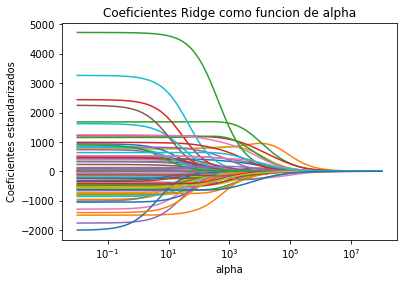

In [10]:
#Análisis previo de los alpha
alphas_ridge = np.logspace(-2, 8,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

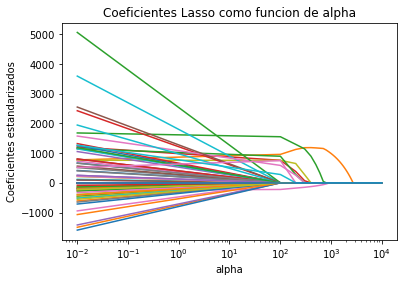

In [11]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,10000,100)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

### GridSearch para otros algoritmos de regresión

In [12]:
#Inicializo pipelines de regresión
pipe_linr = Pipeline([('scl', None),
                    ('linr', linear_model.LinearRegression())])
pipe_ridge = Pipeline([('scl', None),
                    ('ridge', linear_model.Ridge(random_state=50))])
pipe_lasso = Pipeline([('scl', None),
                    ('lasso',linear_model.Lasso(random_state=50))])

# Parámetros para diversos pipelines
linr_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    }]

ridge_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'ridge__alpha': np.logspace(-2, 8,400)
                    }]

lasso_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'lasso__alpha': np.linspace(0.01,10000,100),
                    'lasso__max_iter': [10000],
                    }]

linr_grid_search = GridSearchCV(estimator=pipe_linr,
                        param_grid = linr_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

ridge_grid_search = GridSearchCV(estimator=pipe_ridge,
                        param_grid = ridge_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

lasso_grid_search = GridSearchCV(estimator=pipe_lasso,
                        param_grid = lasso_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')


grids = [linr_grid_search, ridge_grid_search, lasso_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.7s finished
The least populated class in y has only 1 members, which is less than n_splits=5.


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.9min finished


---
## Análisis

In [13]:
models = [
        {
        'name':'Linear Regression',
        'model': grids[0].best_estimator_
        },
        {
        'name':'Ridge',
        'model': grids[1].best_estimator_
        },
        {
        'name':'Lasso',
        'model': grids[2].best_estimator_
        },
        {
        'name':'XGBoost',
        'model': xgb_model
        },
        {
        'name':'LGBoost',
        'model': lgb_model
        },
        {
        'name':'CatBoost',
        'model': ctb_model
        },
        {
        'name':'Random Forest',
        'model': rndfo_model
        },
    ]

list=[]

for key in models:
    list.append(pd.DataFrame(getscores(key["model"],X_test,y_test,X_train,y_train,key["name"]),index=['MSE Test','RMSE Test','MAE Test','R2 Test','MSE Train','RMSE Train','MAE Train','R2 Train']))
    
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.concat(list,axis=1)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Linear Regression,Ridge,Lasso,XGBoost,LGBoost,CatBoost,Random Forest
MSE Test,13814807.09208,13819521.32951,13814687.59072,8513509.21981,9212629.14190,8597537.53536,11234182.95019
RMSE Test,3716.82756,3717.46168,3716.81148,2917.79184,3035.23132,2932.15578,3351.74327
MAE Test,2443.78535,2443.51480,2443.75208,1858.00922,1988.81364,1886.03961,2199.52499
R2 Test,0.35916,0.35894,0.35917,0.60508,0.57265,0.60118,0.47887
MSE Train,13566672.57114,13570330.41171,13566678.16248,2258558.24771,4366037.97060,2893617.20846,9642251.15397
RMSE Train,3683.29643,3683.79294,3683.29719,1502.85004,2089.50663,1701.06355,3105.19744
MAE Train,2454.33078,2453.38578,2454.28400,911.92730,1381.29956,1127.43287,2093.95478
R2 Train,0.37159,0.37142,0.37159,0.89538,0.79776,0.86597,0.55337


#### Gráficos LR

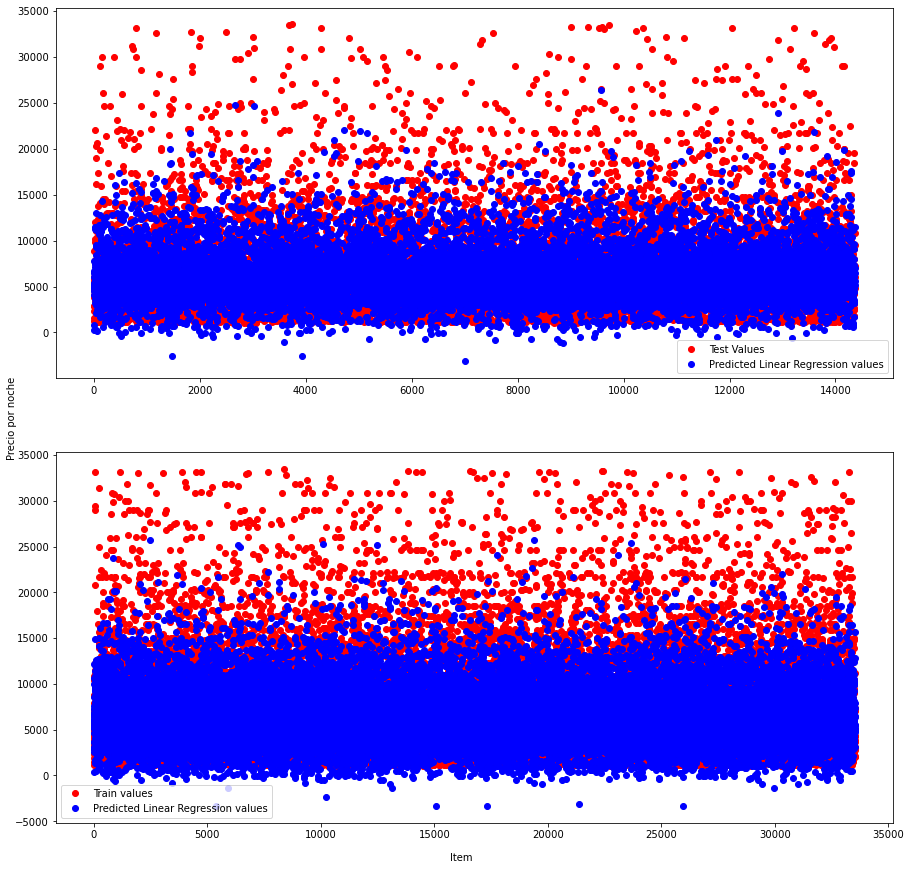

In [14]:
#Linear Regression
y_test_prediction = models[0]["model"].predict(X_test)
y_train_prediction = models[0]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[0]["name"])

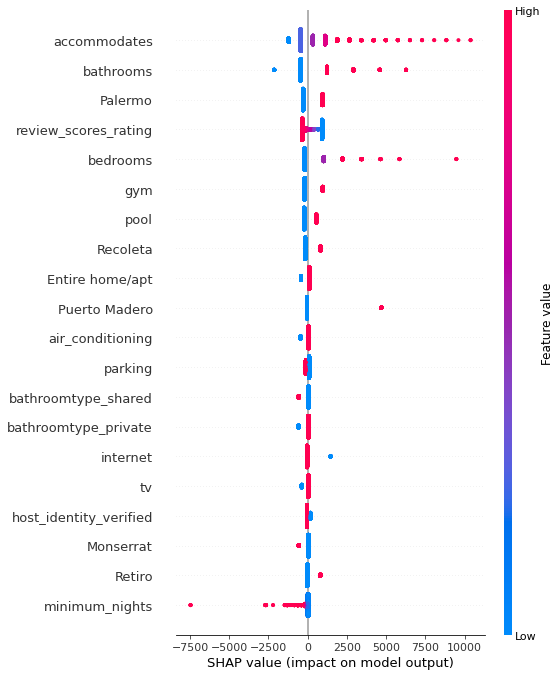

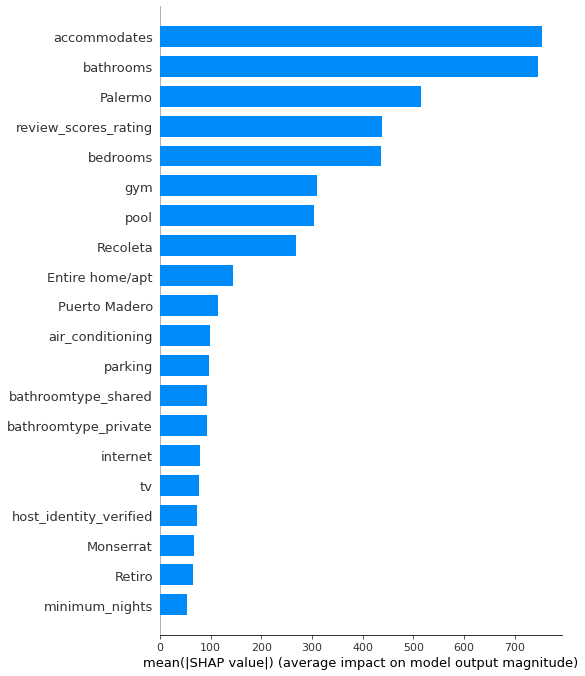

In [15]:
explainer = shap.LinearExplainer(linear_model.LinearRegression().fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Ridge

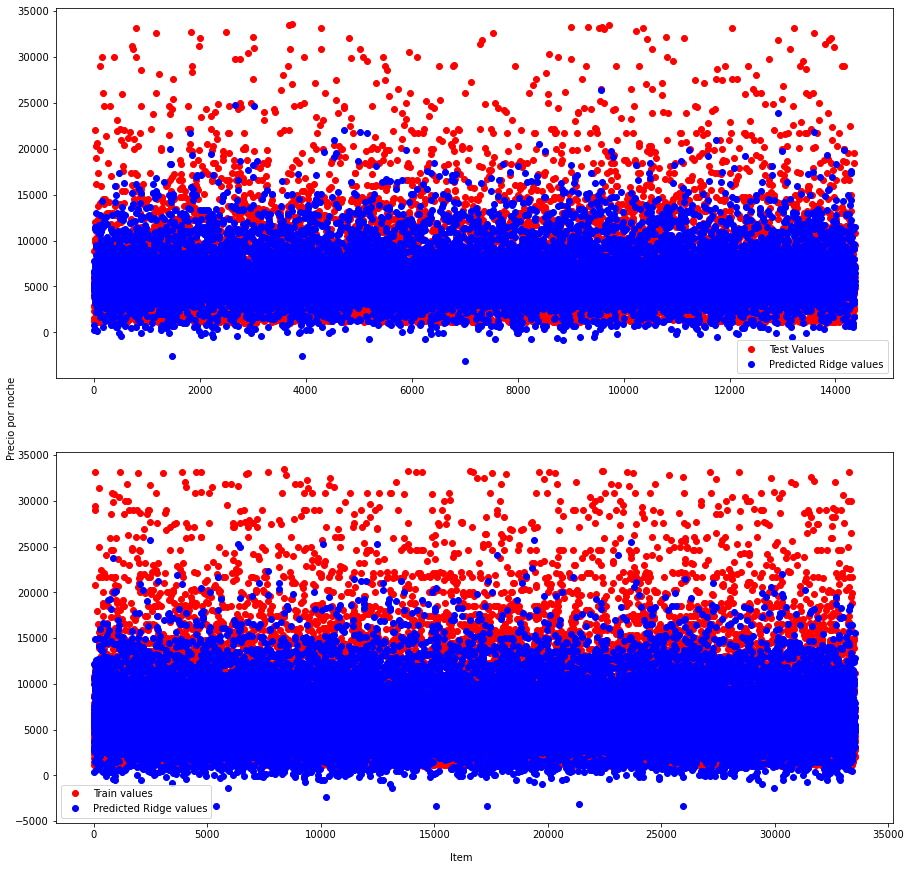

In [16]:
#Ridge
y_test_prediction = models[1]["model"].predict(X_test)
y_train_prediction = models[1]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[1]["name"])

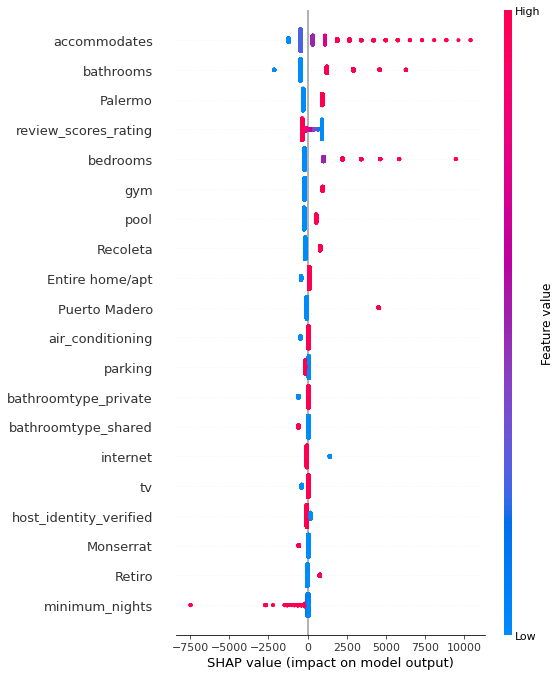

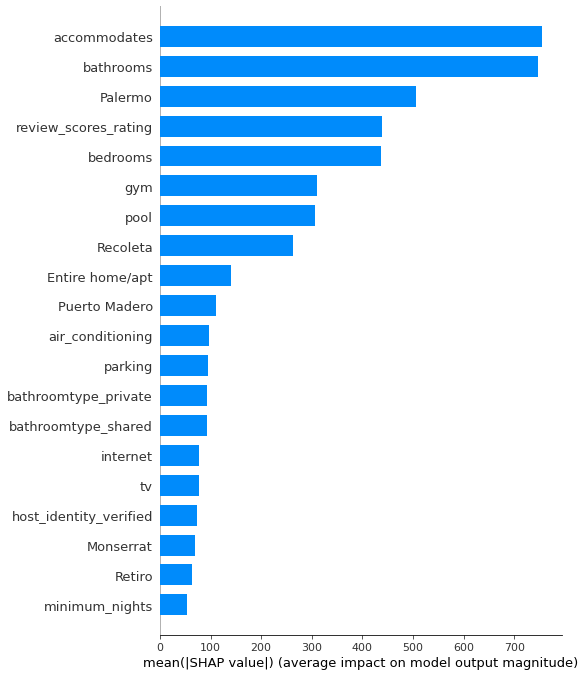

In [17]:
explainer = shap.LinearExplainer(linear_model.Ridge(alpha=models[1]["model"].steps[1][1].alpha,random_state=models[1]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Lasso

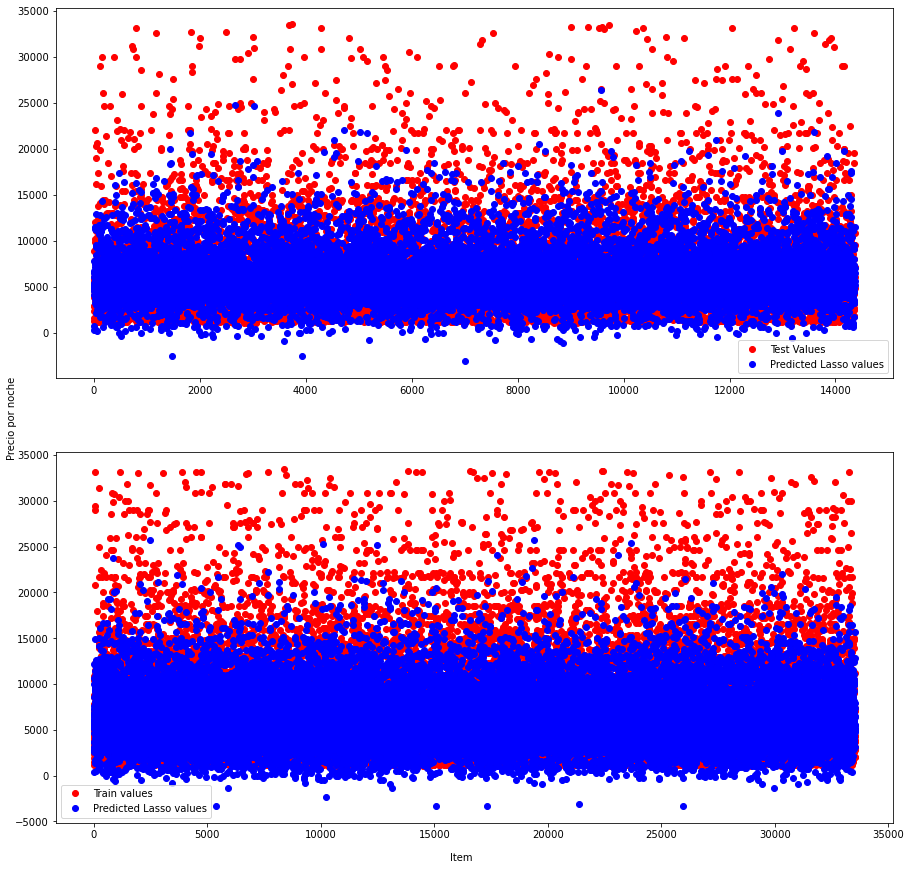

In [18]:
#Lasso
y_test_prediction = models[2]["model"].predict(X_test)
y_train_prediction = models[2]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[2]["name"])

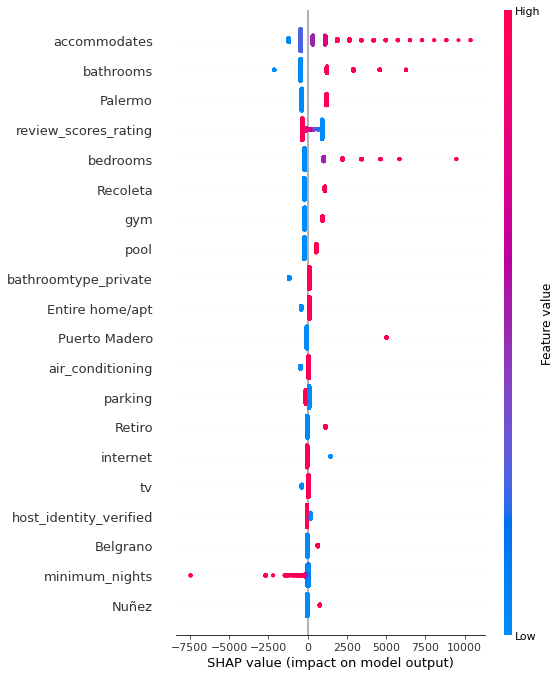

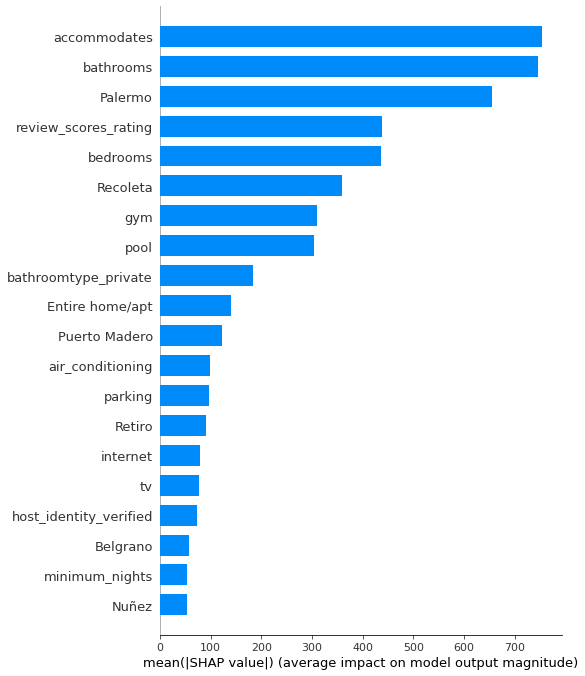

In [19]:
explainer = shap.LinearExplainer(linear_model.Lasso(alpha=models[2]["model"].steps[1][1].alpha,max_iter=models[2]["model"].steps[1][1].max_iter,random_state=models[2]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos XGBoost

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


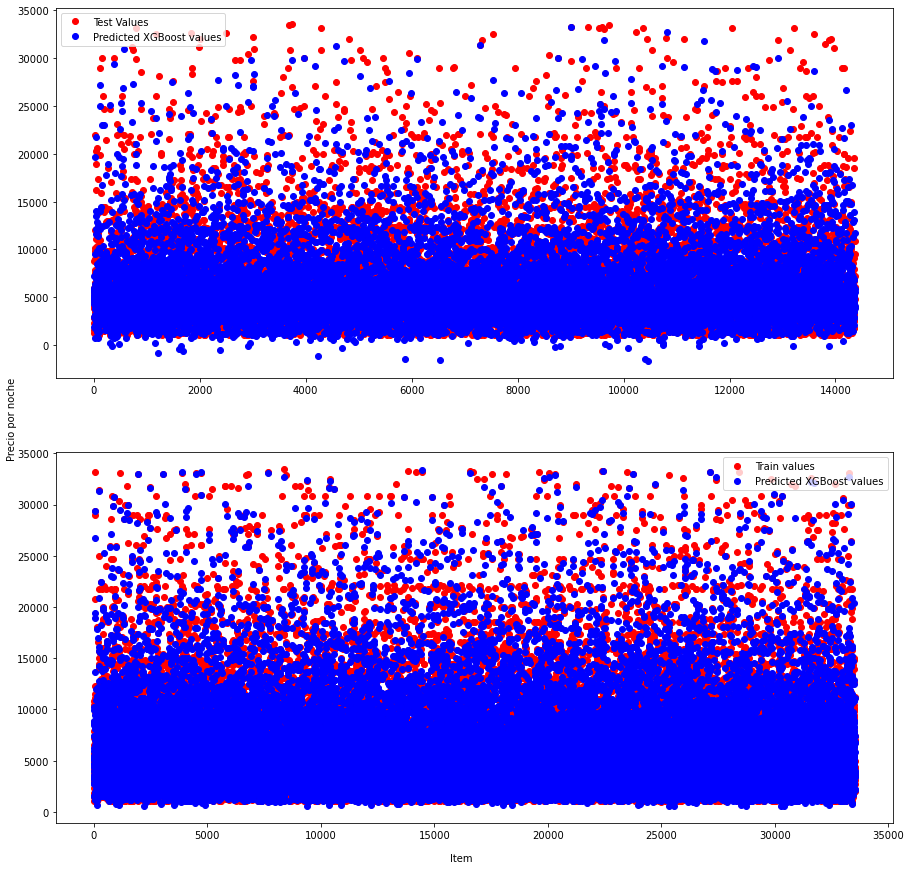

In [20]:
#XGBoost
y_test_prediction = models[3]["model"].predict(X_test)
y_train_prediction = models[3]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[3]["name"])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


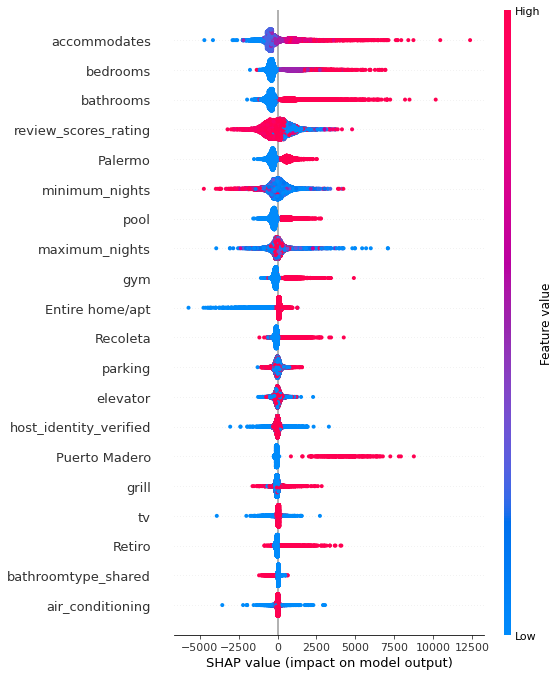

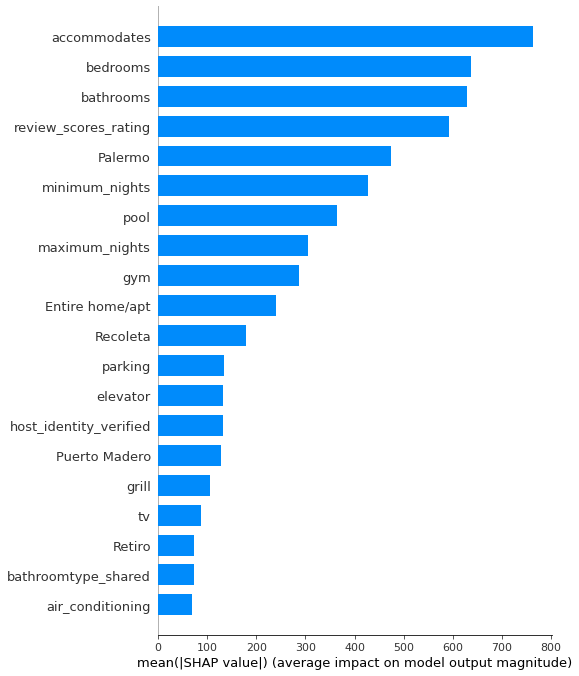

In [21]:
explainer = shap.TreeExplainer(models[3]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos LGBoost

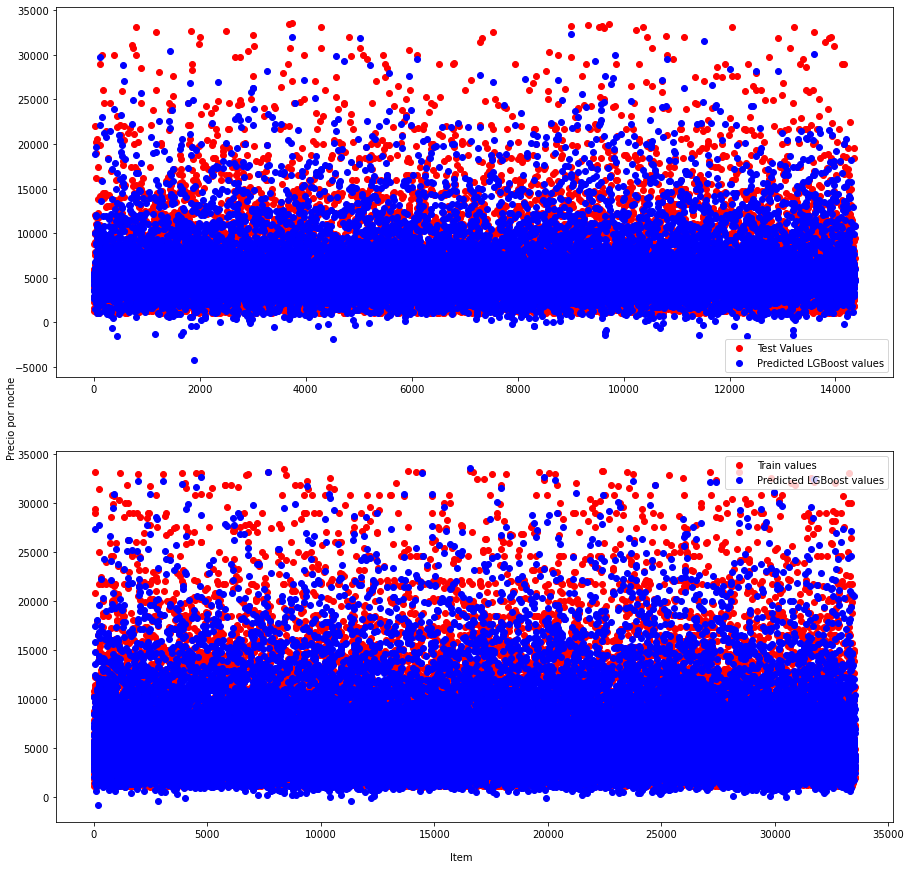

In [22]:
#LGBoost
y_test_prediction = models[4]["model"].predict(X_test)
y_train_prediction = models[4]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[4]["name"])

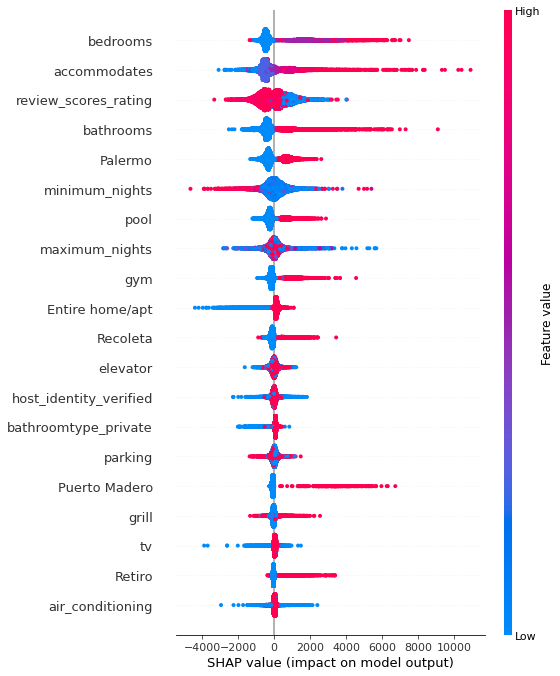

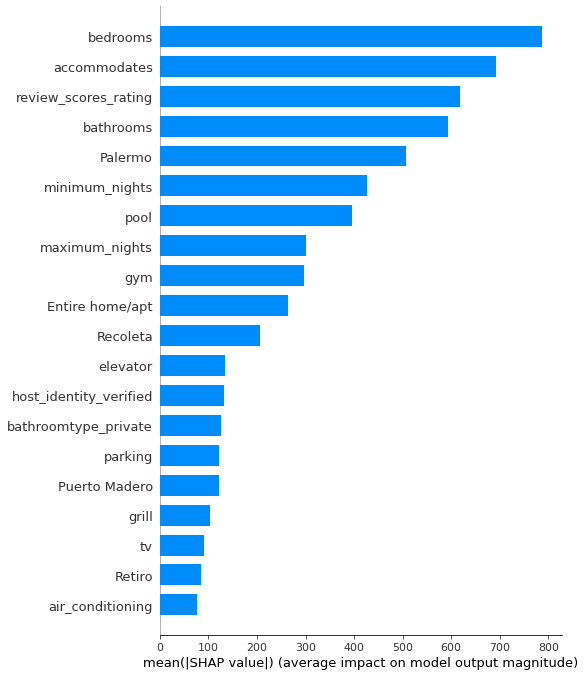

In [23]:
explainer = shap.TreeExplainer(models[4]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos CatBoost

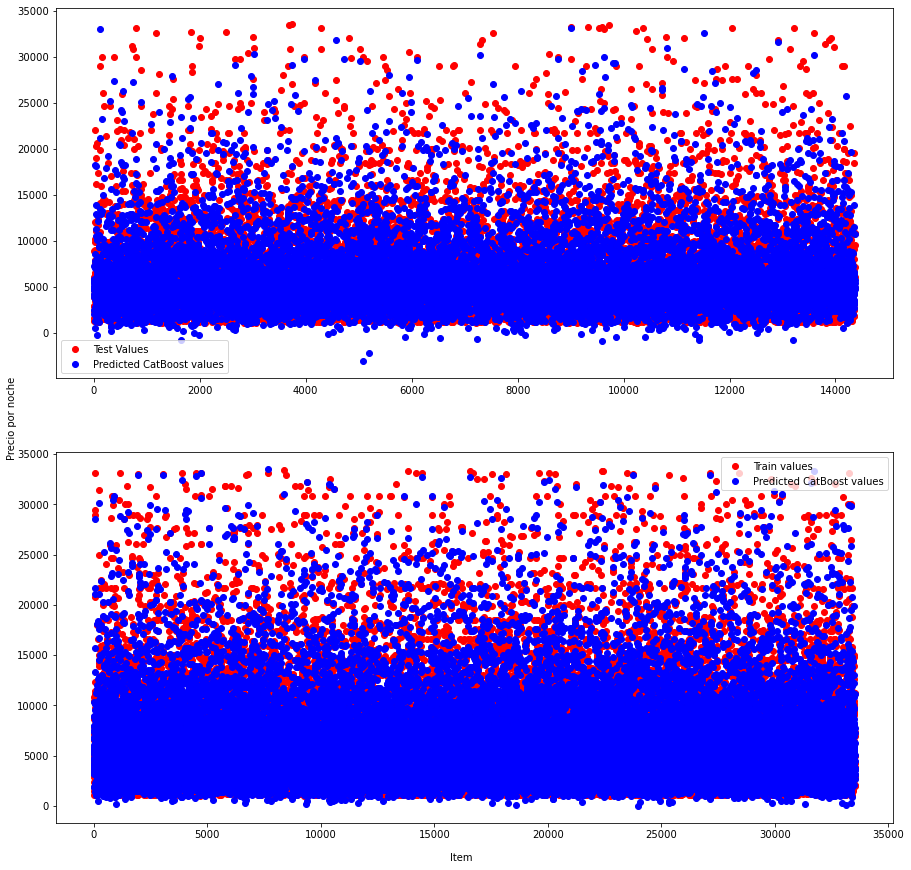

In [24]:
#LGBoost
y_test_prediction = models[5]["model"].predict(X_test)
y_train_prediction = models[5]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[5]["name"])

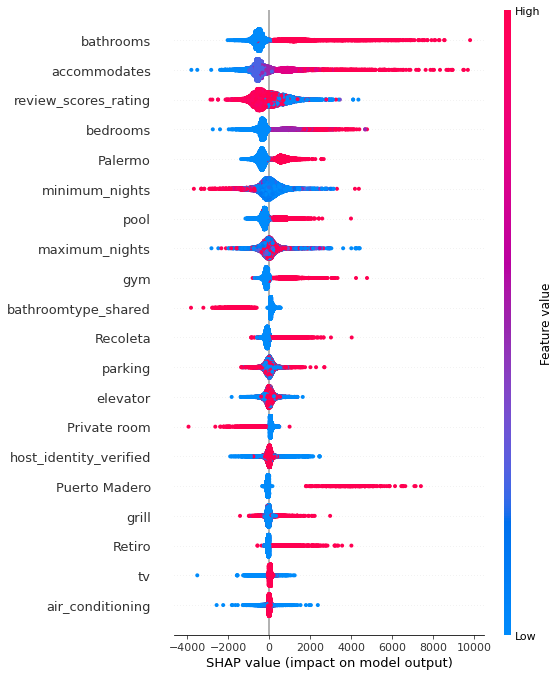

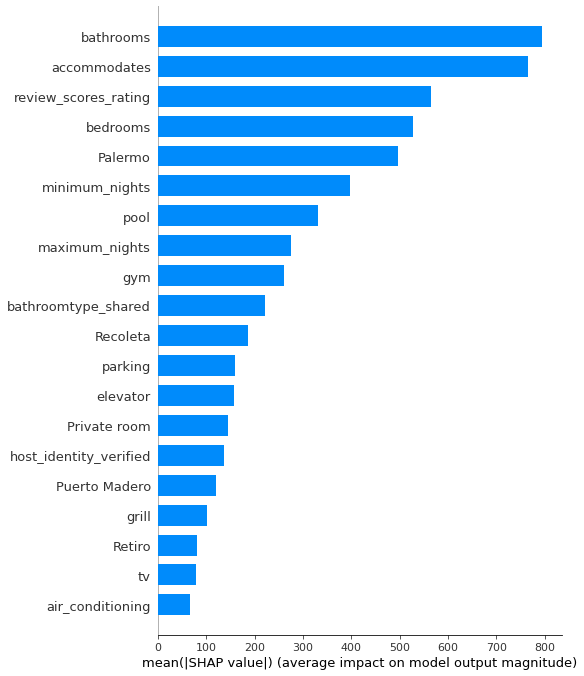

In [25]:
explainer = shap.TreeExplainer(models[5]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Random Forest

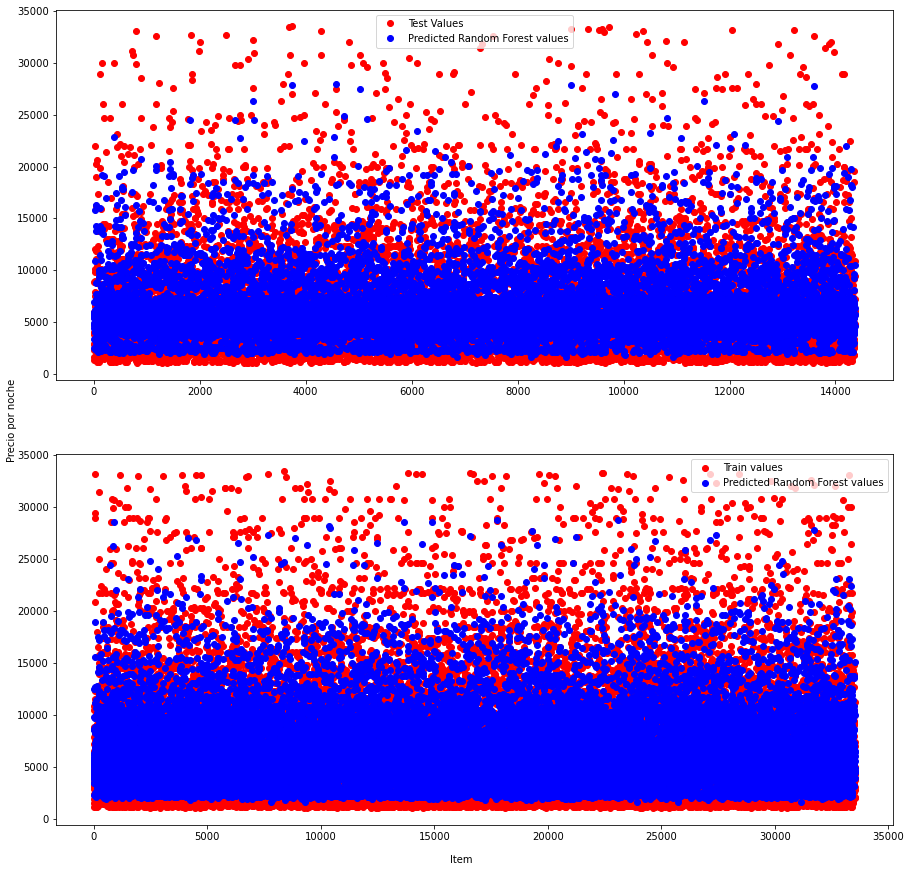

In [26]:
y_test_prediction = models[6]["model"].predict(X_test)
y_train_prediction = models[6]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[6]["name"])

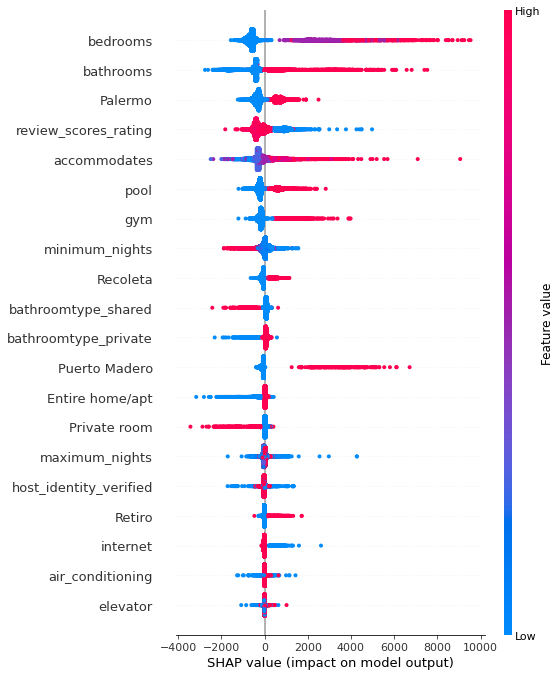

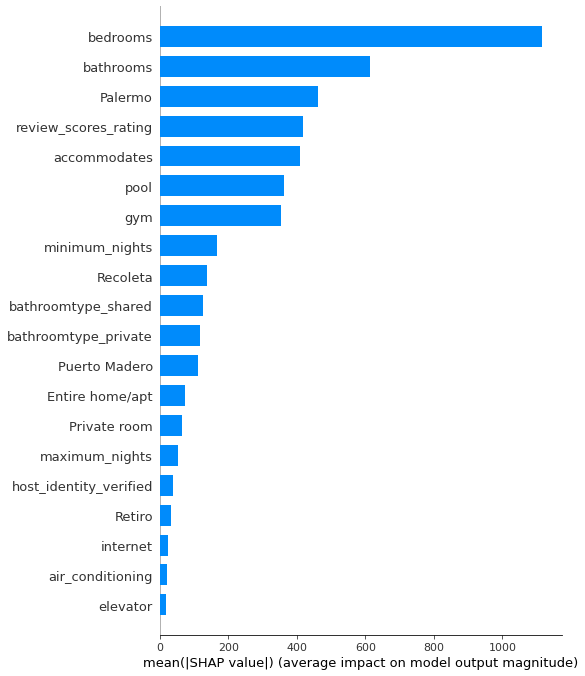

In [27]:
explainer = shap.TreeExplainer(models[6]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

## Modelo

In [30]:
joblib.dump(models[5]["model"],'model2.sav')

['model2.sav']

In [31]:
models[5]["model"]